# Notiz für Henry:
diese Datei ist dafür da das Neuronale Netz zu entwickeln. In einem Notebook kann man schneller Hyperparameter ändern und einfacher weitere kleine Änderungen vornehmen. Wenn das Gröbste steht können wir das Notebook einfach als .py Datei exportieren und sind happy

Korrelationen für Pop

Cluster in Pop?

Pop in Cluster aufteilen

eventuell auch mit Rock?

Hyperparameter optimieren

## Importieren der wichtigsten Pakete

In [110]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

In [111]:
# GPU Test
import tensorflow as tf

# Funktioniert momentan bei mir immernoch nicht
#if tf.test.is_gpu_available():
#   print("GPU is available")
#   print("GPU(s) that Tensorflow recognizes:", tf.config.list_physical_devices('GPU'))
#else:
#   print("GPU not available")
# Manuell auf CPU einschränken
tf.config.set_visible_devices([], 'GPU')

## Sinnvolle Funktionen

In [112]:
################################################################################################### 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
###################################################################################################    

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        value = f'{cm[i, j]:.3f}'  # Runde den Wert auf 3 Dezimalstellen
        plt.text(j, i, value,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
################################################################################################### 
import matplotlib.cm as cm
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[n]).reshape((28,28)), cmap=cm.Greys, interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[n],obs_errors[n]))
            n += 1
            
################################################################################################### 

In [113]:
def evaluate(X_test, Y_test):
    # Make predictions on test data
    Y_pred = model.predict(X_test)
    # Calculate loss and accuracy
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f"loss:     {loss:.3}")
    print(f"accuracy: {accuracy:.3}")

    # Compute the classification report
    report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    print(report)
    
    # Plot probability of being zero for true !genre! and non-!genre!
    true_genre = np.where(np.argmax(Y_test, axis=1) == 0)[0]
    true_non_genre = np.where(np.argmax(Y_test, axis=1) != 0)[0]
    
    plt.figure()
    plt.hist(Y_pred[true_genre, 0], bins=50, color='red', label='True !genre!', alpha=0.5)
    plt.hist(Y_pred[true_non_genre, 0], bins=50, color='blue', label='True Non-!genre!', alpha=0.5)
    plt.xlabel('Probability of !hier genre einfügen!')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(confusion_mtx, classes=range(10), normalize='true')  

## Laden der Daten
Am besten wir fügen das Genre in einer separaten Datei dem Datensatz hinzu und machen ab hier nur mit dem fertigen Datensatz weiter

## Convert target

In [131]:
#csv_file = "../data/data_selected.csv"
csv_file = "../data/data_selected_v1.csv"

df = pd.read_csv(csv_file)
df.columns

Index(['Unnamed: 0', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Comments',
       'Stream', 'Genre', 'Artist_encoded', 'Album_type_encoded',
       'Licensed_encoded', 'official_video_encoded'],
      dtype='object')

In [132]:
df = df.loc[~df["Genre"].isin(["bullshit"])]
#df = df.loc[~df["Genre"].isin(["country"])]
#df = df.loc[~df["Genre"].isin(["raggae"])]
#df = df.loc[~df["Genre"].isin(["rock"])]
#df = df.loc[~df["Genre"].isin(["soul"])]
#df = df.loc[~df["Genre"].isin(["folk"])]
#df = df.loc[~df["Genre"].isin(["pop"])]

genres_to_keep = ["classic", "metal", "rock", "hip hop"]
df = df[df['Genre'].isin(genres_to_keep)]

n=100
genre_counts = df["Genre"].value_counts()
df= df[df["Genre"].isin(genre_counts[genre_counts > n].index)]

In [133]:
features_drop = ['Genre', 'Unnamed: 0']

df = df.sample(frac=1, random_state=42) #daten mischen

X = df.drop(features_drop, axis=1)
Y = df['Genre']

In [134]:
# One-Hot-Encoding durchführen
Y = pd.get_dummies(Y)

# label um One-Hot-Encoding hinterher wieder zu übersetzen
genre_mapping = Y.columns
label = []
for index, genre in enumerate(genre_mapping):
    label.append(genre)
    print("Genre", index, ":", genre)


Genre 0 : classic
Genre 1 : hip hop
Genre 2 : metal
Genre 3 : rock


## Splitten von Training und Test Datensätzen

In [135]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.3, stratify=Y_train, random_state=42)

In [136]:
#from sklearn.model_selection import StratifiedShuffleSplit

# Erstellen Sie den StratifiedShuffleSplit-Teiler
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Verwenden Sie den Teiler, um Ihre Daten in Trainings- und Testsets aufzuteilen.
#for train_index, test_index in sss.split(X, Y):
#    X_train, X_test = X[train_index], X[test_index]
#    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Erstellen Sie einen zweiten StratifiedShuffleSplit-Teiler für das Validierungsset
#    sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    
#    for train_index, val_index in sss_val.split(X_train, Y_train):
#        X_train, X_val = X_train[train_index], X_train[val_index]
#        Y_train, Y_val = Y_train[train_index], Y_train[val_index]


## Daten skalieren

In [137]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Gewichte berechnen um Überrepräsentation zu vermeiden

In [138]:
from sklearn.utils.class_weight import compute_class_weight

num_classes = len(Y.value_counts())
class_counts = np.sum(Y_train, axis=0)
total_samples = np.sum(class_counts)
class_weights = total_samples / (num_classes * class_counts)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Anpassung der Gewichte auf das One-Hot-kodierte Y_train
Y_train_encoded = np.argmax(Y_train, axis=1)
sample_weights = np.array([class_weights_dict[class_label] for class_label in Y_train_encoded])

# Transformieren, damit die wichtigsten Klassen nicht unterrepräsentiert sind 
# TODO: finde eine gute Funktion dafür
#transformed_weights = np.log(sample_weights + 1) #log acc~25% -> funktioniert glaube ich am besten
#transformed_weights = sample_weights ** 2 # square acc~10% -> der ist ziemlich kacke
#transformed_weights = np.exp(sample_weights) # exp acc~7%
transformed_weights = 1 / (1 + np.exp(-sample_weights)) #sigmoid acc~40%


## Modell
hier ein schönes Modell ergänzen

In [139]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], jit_compile=False)


In [140]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                1280      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               33024     
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 512)              

## Training

In [141]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

batch_size = 32
nb_epoch = 300

# Definiere die Early Stopping-Bedingungen
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Definiere die Reduzierung der Lernrate, falls die Verbesserung stagniert
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min', min_lr=1e-7)

hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                 epochs=nb_epoch, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
#hist = model.fit(X_train, Y_train, sample_weight=transformed_weights, validation_data=(X_val, Y_val), 
#                 epochs=nb_epoch, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

Epoch 1/300
75/75 [==============================] - 3s 17ms/step - loss: 1.1096 - accuracy: 0.5311 - val_loss: 0.8217 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 2/300
75/75 [==============================] - 1s 13ms/step - loss: 0.8323 - accuracy: 0.6815 - val_loss: 0.6081 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 3/300
75/75 [==============================] - 1s 11ms/step - loss: 0.7155 - accuracy: 0.7286 - val_loss: 0.5613 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 4/300
75/75 [==============================] - 1s 10ms/step - loss: 0.6904 - accuracy: 0.7462 - val_loss: 0.5495 - val_accuracy: 0.8245 - lr: 0.0010
Epoch 5/300
75/75 [==============================] - 1s 11ms/step - loss: 0.6567 - accuracy: 0.7605 - val_loss: 0.5368 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 6/300
75/75 [==============================] - 1s 9ms/step - loss: 0.6060 - accuracy: 0.7672 - val_loss: 0.4915 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 7/300
75/75 [==============================] - 1s 9ms/step - loss

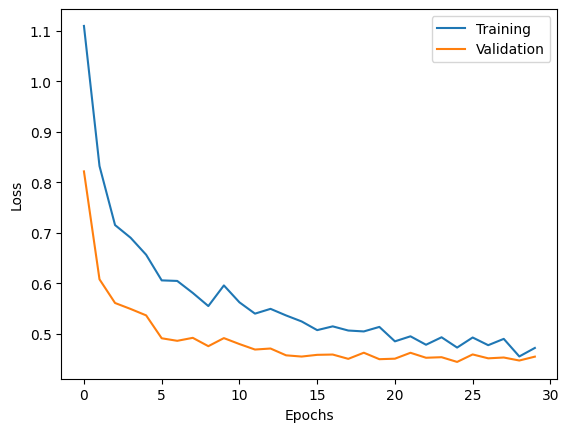

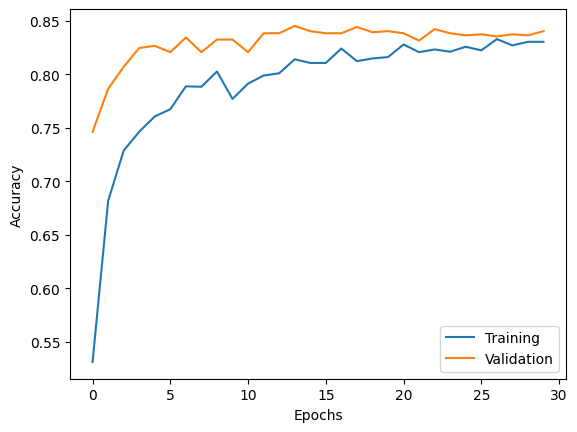

In [142]:
plot_history(hist)

## Vorhersage

In [143]:
Y_pred = model.predict(X_test)

46/46 [==============================] - 0s 4ms/step


In [144]:
#import matplotlib.pyplot as plt
#
#for i in range(len(label)):
#    genre = label[i]
#    probabilities = Y_pred[:, i]
    
#    plt.figure()
#    plt.hist(probabilities, bins=50)
#    plt.xlabel('Wahrscheinlichkeit')
#    plt.ylabel('Anzahl der Vorhersagen')
#    plt.yscale("log")
#    plt.title(f'Genre: {genre}')


## Evaluation

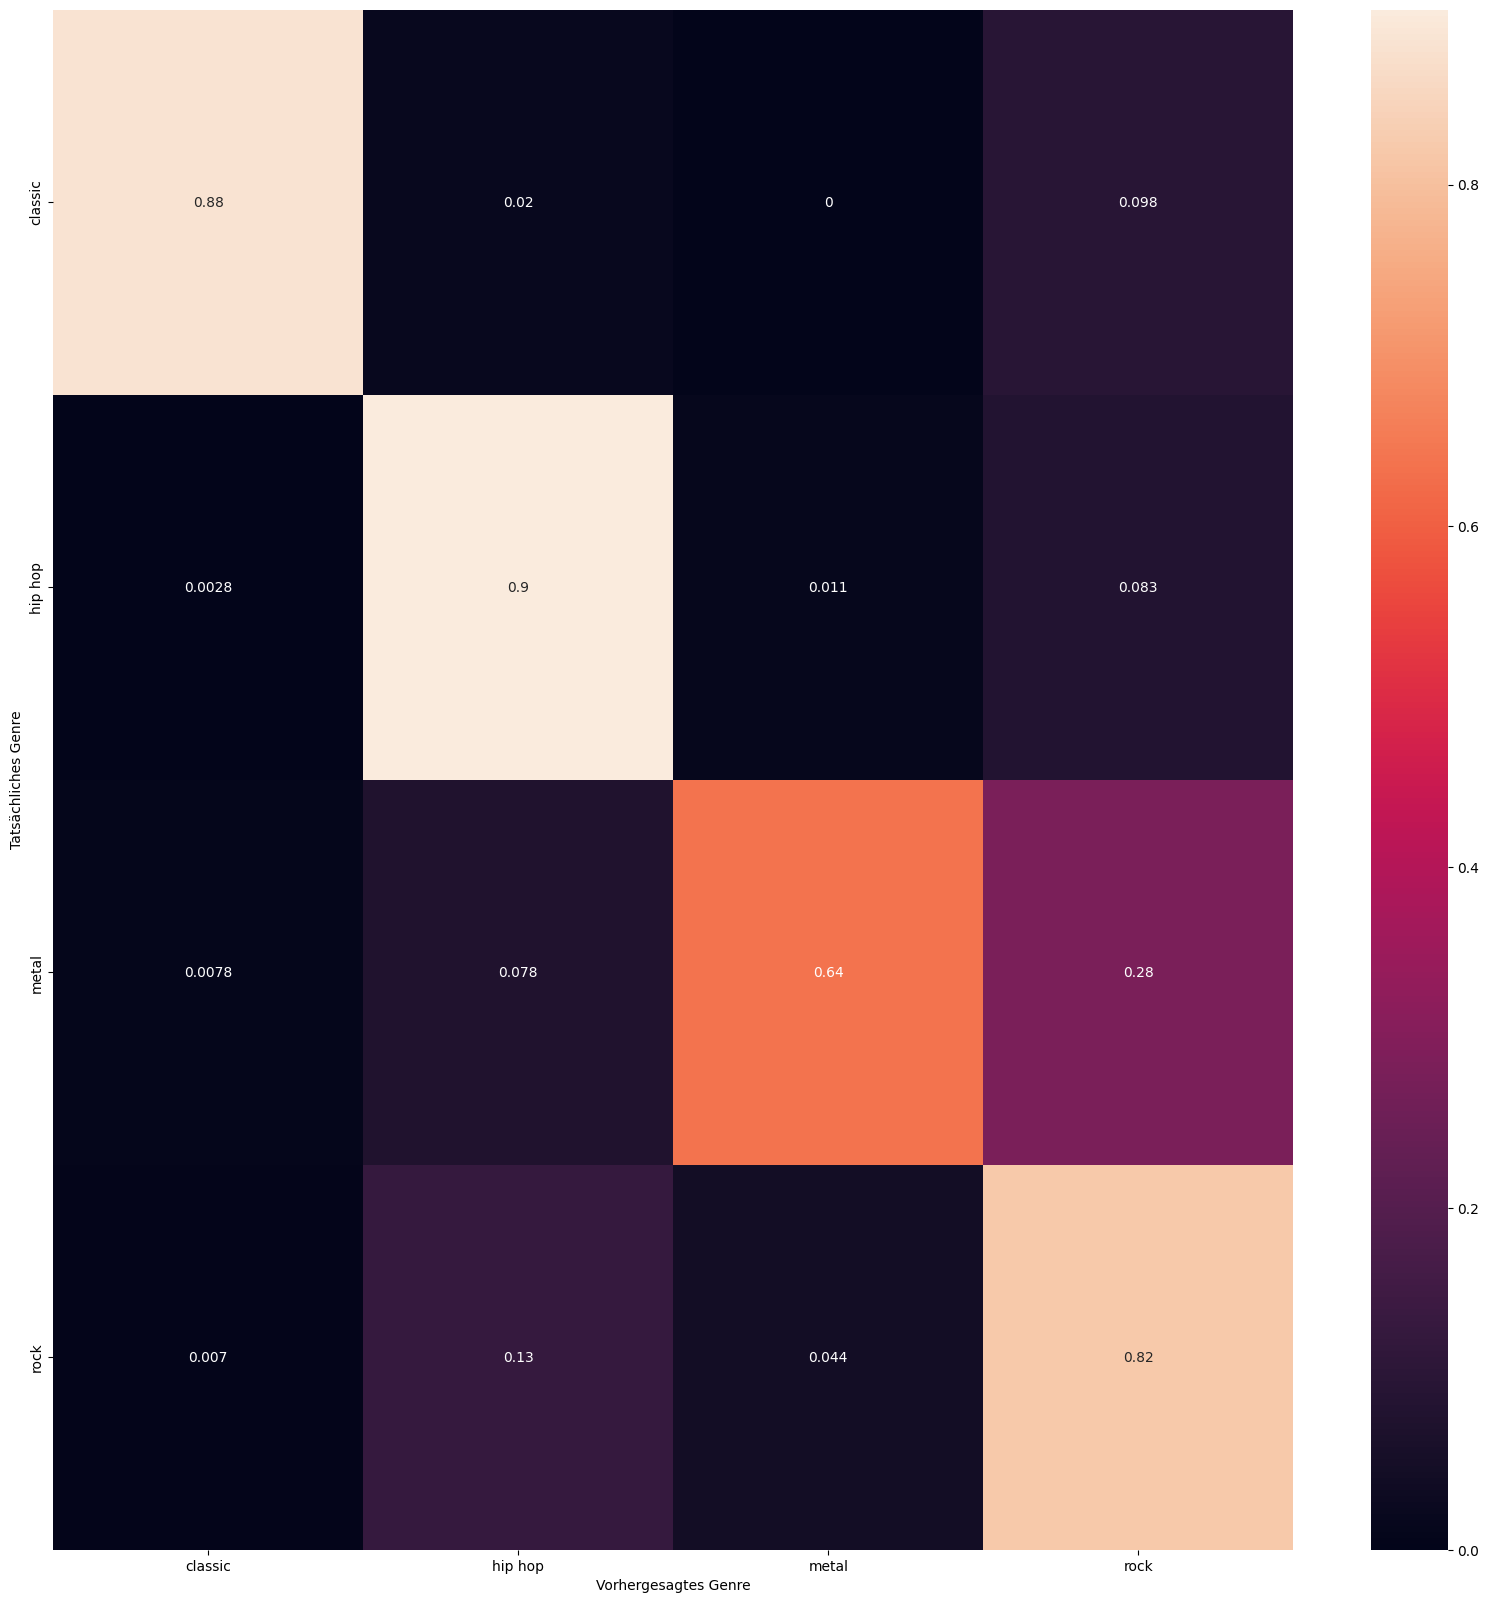

In [148]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

for i in range(len(Y_pred_classes)):
    if label[Y_pred_classes[i]] == 'pop' and Y_pred[i, Y_pred_classes[i]] > 0.9:
        # Finde den Index des zweithöchsten Werts
        second_highest_index = np.argsort(Y_pred[i])[-2]
        Y_pred_classes[i] = second_highest_index
Y_test_classes = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_test_classes, Y_pred_classes, normalize='true')
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label)
plt.xlabel('Vorhergesagtes Genre')
plt.ylabel('Tatsächliches Genre')
plt.savefig('../figures/confusion_matrix.png')
plt.show()


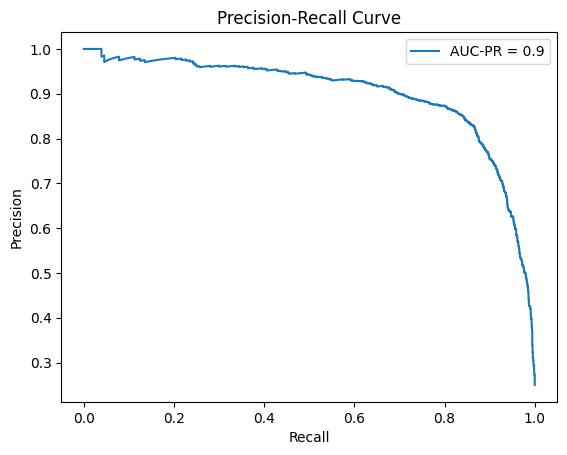

In [146]:
# Precision-Recall Curve
#-> die sollte eigentlich anders aussehen...

from sklearn.metrics import precision_recall_curve, auc

Y_prob = Y_pred

if isinstance(Y_test, pd.DataFrame):
    Y_test = Y_test.values
if isinstance(Y_prob, pd.DataFrame):
    Y_prob = Y_prob.values

precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())


# Berechne Precision, Recall und Schwellenwerte
precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())

# Berechne den AUC-PR
auc_pr = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()


hip hop: AUC-PR = 0.941
classic: AUC-PR = 0.901
rock: AUC-PR = 0.87
metal: AUC-PR = 0.702


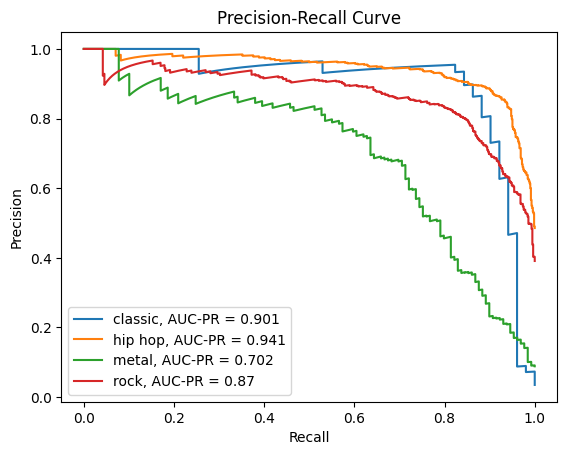

In [147]:
# Precision Recall Curve für jede Klasse einzeln

n_classes = Y_test.shape[1]

if isinstance(Y_test, np.ndarray):
    Y_test = pd.DataFrame(Y_test)
if isinstance(Y_pred, np.ndarray):
    Y_pred = pd.DataFrame(Y_pred)

auc_pr_values = []

# Für jede Klasse
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(Y_test.iloc[:, i], Y_pred.iloc[:, i])

    # Berechne den AUC-PR
    auc_pr = auc(recall, precision)
    auc_pr_values.append((label[i], auc_pr))

    plt.plot(
        recall,
        precision,
        label=f"{label[i]}, AUC-PR = {auc_pr:.3}",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")

# Genres nach AUC-PR-Wert sortieren
auc_pr_values_sorted = sorted(auc_pr_values, key=lambda x: x[1], reverse=True)

# Ausgabe der Genres und AUC-PR-Werte
for genre, auc_pr in auc_pr_values_sorted:
    print(f"{genre}: AUC-PR = {auc_pr:.3}")

## Hyperparameter Optimierung 
scheint noch nicht richtig zu laufen

In [153]:
#random search

from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Funktion zum Erstellen des Modells
def create_model(units_1=64, units_2=128, units_3=256, units_4=512, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(units=units_1, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_3, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_4, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Wrapper für das Keras-Modell
model = KerasClassifier(build_fn=create_model)

# Hyperparameter-Raster
param_grid = {
    'units_1': [64, 128, 256],
    'units_2': [128, 256, 512],
    'units_3': [256, 512, 1024],
    'units_4': [512, 1024, 2048],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Random Search durchführen
random_search = RandomizedSearchCV(model, param_distributions=param_grid, cv=3, n_iter=10)
random_search.fit(X_train, Y_train)

# Beste Parameter und Ergebnisse anzeigen
print("Beste Parameter: ", random_search.best_params_)
print("Bestes Ergebnis: ", random_search.best_score_)


/tmp/ipykernel_28160/307962056.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


75/75 [==============================] - 6s 60ms/step - loss: 0.9057 - accuracy: 0.6521
Beste Parameter:  {'units_4': 2048, 'units_3': 1024, 'units_2': 256, 'units_1': 128, 'dropout_rate': 0.5}
Bestes Ergebnis:  0.7962238788604736


In [154]:
# grid search

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Funktion zum Erstellen des Modells
def create_model(units_1=64, units_2=128, units_3=256, units_4=512, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(units=units_1, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_3, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_4, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Wrapper für das Keras-Modell
model = KerasClassifier(build_fn=create_model)

# Hyperparameter-Raster
param_grid = {
    'units_1': [64, 128, 256],
    'units_2': [128, 256, 512],
    'units_3': [256, 512, 1024],
    'units_4': [512, 1024, 2048],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Grid Search durchführen
grid_search = GridSearchCV(model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, Y_train)

# Beste Parameter und Ergebnisse anzeigen
print("Beste Parameter: ", grid_search.best_params_)
print("Bestes Ergebnis: ", grid_search.best_score_)


/tmp/ipykernel_28160/1576071205.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


75/75 [==============================] - 6s 37ms/step - loss: 0.7303 - accuracy: 0.7391
Beste Parameter:  {'dropout_rate': 0.3, 'units_1': 256, 'units_2': 512, 'units_3': 512, 'units_4': 2048}
Bestes Ergebnis:  0.8113409479459127


In [164]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
import multiprocessing

# Funktion zum Erstellen des Modells
def create_model(units_1, units_2, units_3, units_4, dropout_rate):
    model = Sequential()
    model.add(Dense(units=units_1, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_3, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units_4, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Wrapper für das Keras-Modell
model = KerasClassifier(build_fn=create_model)

# Hyperparameter-Raster
param_grid = {
    'units_1': [64, 128, 256],
    'units_2': [128, 256, 512],
    'units_3': [256, 512, 1024],
    'units_4': [512, 1024, 2048],
    'dropout_rate': [0.3, 0.5, 0.7]
}
#param_grid = {
#    'units_1': [64, 128],
#    'units_2': [128, 256],
#    'units_3': [256, 512],
#    'units_4': [512],
#    'dropout_rate': [0.5]
#}

# k-fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search durchführen
grid_search = GridSearchCV(model, param_grid=param_grid, cv=kfold, n_jobs=multiprocessing.cpu_count())
grid_result = grid_search.fit(X_train, Y_train)

# Beste Parameter und Ergebnisse anzeigen
print("Beste Parameter: ", grid_result.best_params_)
print("Bestes Ergebnis: ", grid_result.best_score_)

# Review the Whole Grid
results = pd.DataFrame(grid_result.cv_results_)
print(results[['params', 'mean_test_score']])


/tmp/ipykernel_28160/3412053769.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


51/60 [========================>.....] - ETA: 0s - loss: 1.3655 - accuracy: 0.4528

/home/christopher/mambaforge/envs/smd/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


15/15 [==============================] - 0s 5ms/step - loss: 1.2012 - accuracy: 0.6849


2023-07-03 16:04:56.473582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


27/60 [============>.................] - ETA: 1s - loss: 1.2526 - accuracy: 0.4769

2023-07-03 16:05:14.689313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


75/75 [==============================] - 4s 19ms/step - loss: 0.7631 - accuracy: 0.7105
Beste Parameter:  {'dropout_rate': 0.3, 'units_1': 256, 'units_2': 128, 'units_3': 1024, 'units_4': 512}
Bestes Ergebnis:  0.8176470518112182
                                                params  mean_test_score
0    {'dropout_rate': 0.3, 'units_1': 64, 'units_2'...         0.777311
1    {'dropout_rate': 0.3, 'units_1': 64, 'units_2'...         0.781933
2    {'dropout_rate': 0.3, 'units_1': 64, 'units_2'...         0.792857
3    {'dropout_rate': 0.3, 'units_1': 64, 'units_2'...         0.773950
4    {'dropout_rate': 0.3, 'units_1': 64, 'units_2'...         0.792437
..                                                 ...              ...
238  {'dropout_rate': 0.7, 'units_1': 256, 'units_2...         0.746639
239  {'dropout_rate': 0.7, 'units_1': 256, 'units_2...         0.760084
240  {'dropout_rate': 0.7, 'units_1': 256, 'units_2...         0.725630
241  {'dropout_rate': 0.7, 'units_1': 256, 'units_

In [208]:
results = results.sort_values('rank_test_score')
results.to_csv('../data/optimization_results.csv', index=False)
results.head(5)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout_rate,param_units_1,param_units_2,param_units_3,param_units_4,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
60,17.812780,2.390832,2.535536,0.472504,0.3,256,128,1024,512,"{'dropout_rate': 0.3, 'units_1': 256, 'units_2...",0.825630,0.825630,0.800420,0.819328,0.817227,0.817647,0.009244,1
53,28.718365,2.309474,2.339015,0.529324,0.3,128,512,1024,2048,"{'dropout_rate': 0.3, 'units_1': 128, 'units_2...",0.806723,0.827731,0.806723,0.804622,0.827731,0.814706,0.010663,2
61,19.664844,0.762018,1.843672,0.461594,0.3,256,128,1024,1024,"{'dropout_rate': 0.3, 'units_1': 256, 'units_2...",0.815126,0.808824,0.823529,0.810924,0.815126,0.814706,0.005042,2
58,16.747440,3.250862,1.980968,0.394881,0.3,256,128,512,1024,"{'dropout_rate': 0.3, 'units_1': 256, 'units_2...",0.810924,0.813025,0.827731,0.806723,0.808824,0.813445,0.007445,4
47,14.296193,2.380568,1.778814,0.293424,0.3,128,512,256,2048,"{'dropout_rate': 0.3, 'units_1': 128, 'units_2...",0.821429,0.806723,0.821429,0.810924,0.804622,0.813025,0.007155,5


## hier das hoffentlich beste Modell

In [212]:
best_params = grid_search.best_params_
model = Sequential()
model.add(Dense(units=best_params['units_1'], activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(units=best_params['units_2'], activation='relu'))
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(units=best_params['units_3'], activation='relu'))
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(units=best_params['units_4'], activation='relu'))
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_780"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3888 (Dense)          (None, 256)               5120      
                                                                 
 dropout_3108 (Dropout)      (None, 256)               0         
                                                                 
 dense_3889 (Dense)          (None, 128)               32896     
                                                                 
 dropout_3109 (Dropout)      (None, 128)               0         
                                                                 
 dense_3890 (Dense)          (None, 1024)              132096    
                                                                 
 dropout_3110 (Dropout)      (None, 1024)              0         
                                                                 
 dense_3891 (Dense)          (None, 512)            

In [213]:
batch_size = 32
nb_epoch = 300

# Definiere die Early Stopping-Bedingungen
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', restore_best_weights=True)

# Definiere die Reduzierung der Lernrate, falls die Verbesserung stagniert
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min', min_lr=1e-7)

hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                 epochs=nb_epoch, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

Epoch 1/300
75/75 [==============================] - 6s 39ms/step - loss: 0.7408 - accuracy: 0.7193 - val_loss: 0.5216 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 2/300
75/75 [==============================] - 2s 32ms/step - loss: 0.5428 - accuracy: 0.7975 - val_loss: 0.5277 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 3/300
75/75 [==============================] - 2s 32ms/step - loss: 0.5102 - accuracy: 0.8214 - val_loss: 0.4670 - val_accuracy: 0.8402 - lr: 0.0010
Epoch 4/300
75/75 [==============================] - 2s 31ms/step - loss: 0.4920 - accuracy: 0.8181 - val_loss: 0.4918 - val_accuracy: 0.8343 - lr: 0.0010
Epoch 5/300
75/75 [==============================] - 2s 32ms/step - loss: 0.4780 - accuracy: 0.8218 - val_loss: 0.4675 - val_accuracy: 0.8412 - lr: 0.0010
Epoch 6/300
75/75 [==============================] - 2s 33ms/step - loss: 0.4736 - accuracy: 0.8265 - val_loss: 0.4834 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 7/300
75/75 [==============================] - 2s 33ms/step - lo

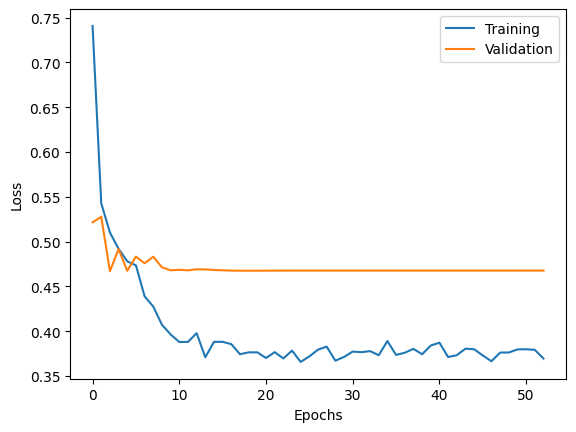

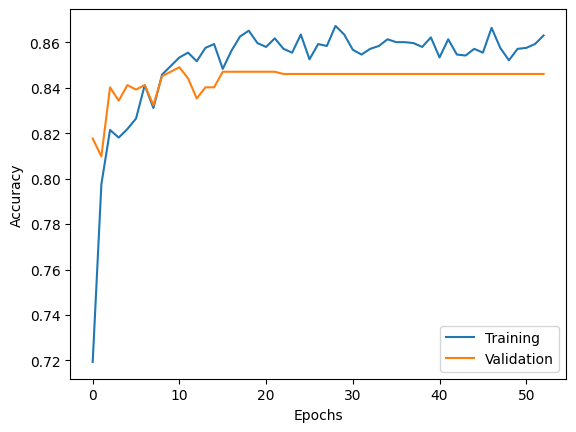

In [214]:
plot_history(hist)

In [215]:
Y_pred = model.predict(X_test)

46/46 [==============================] - 1s 10ms/step


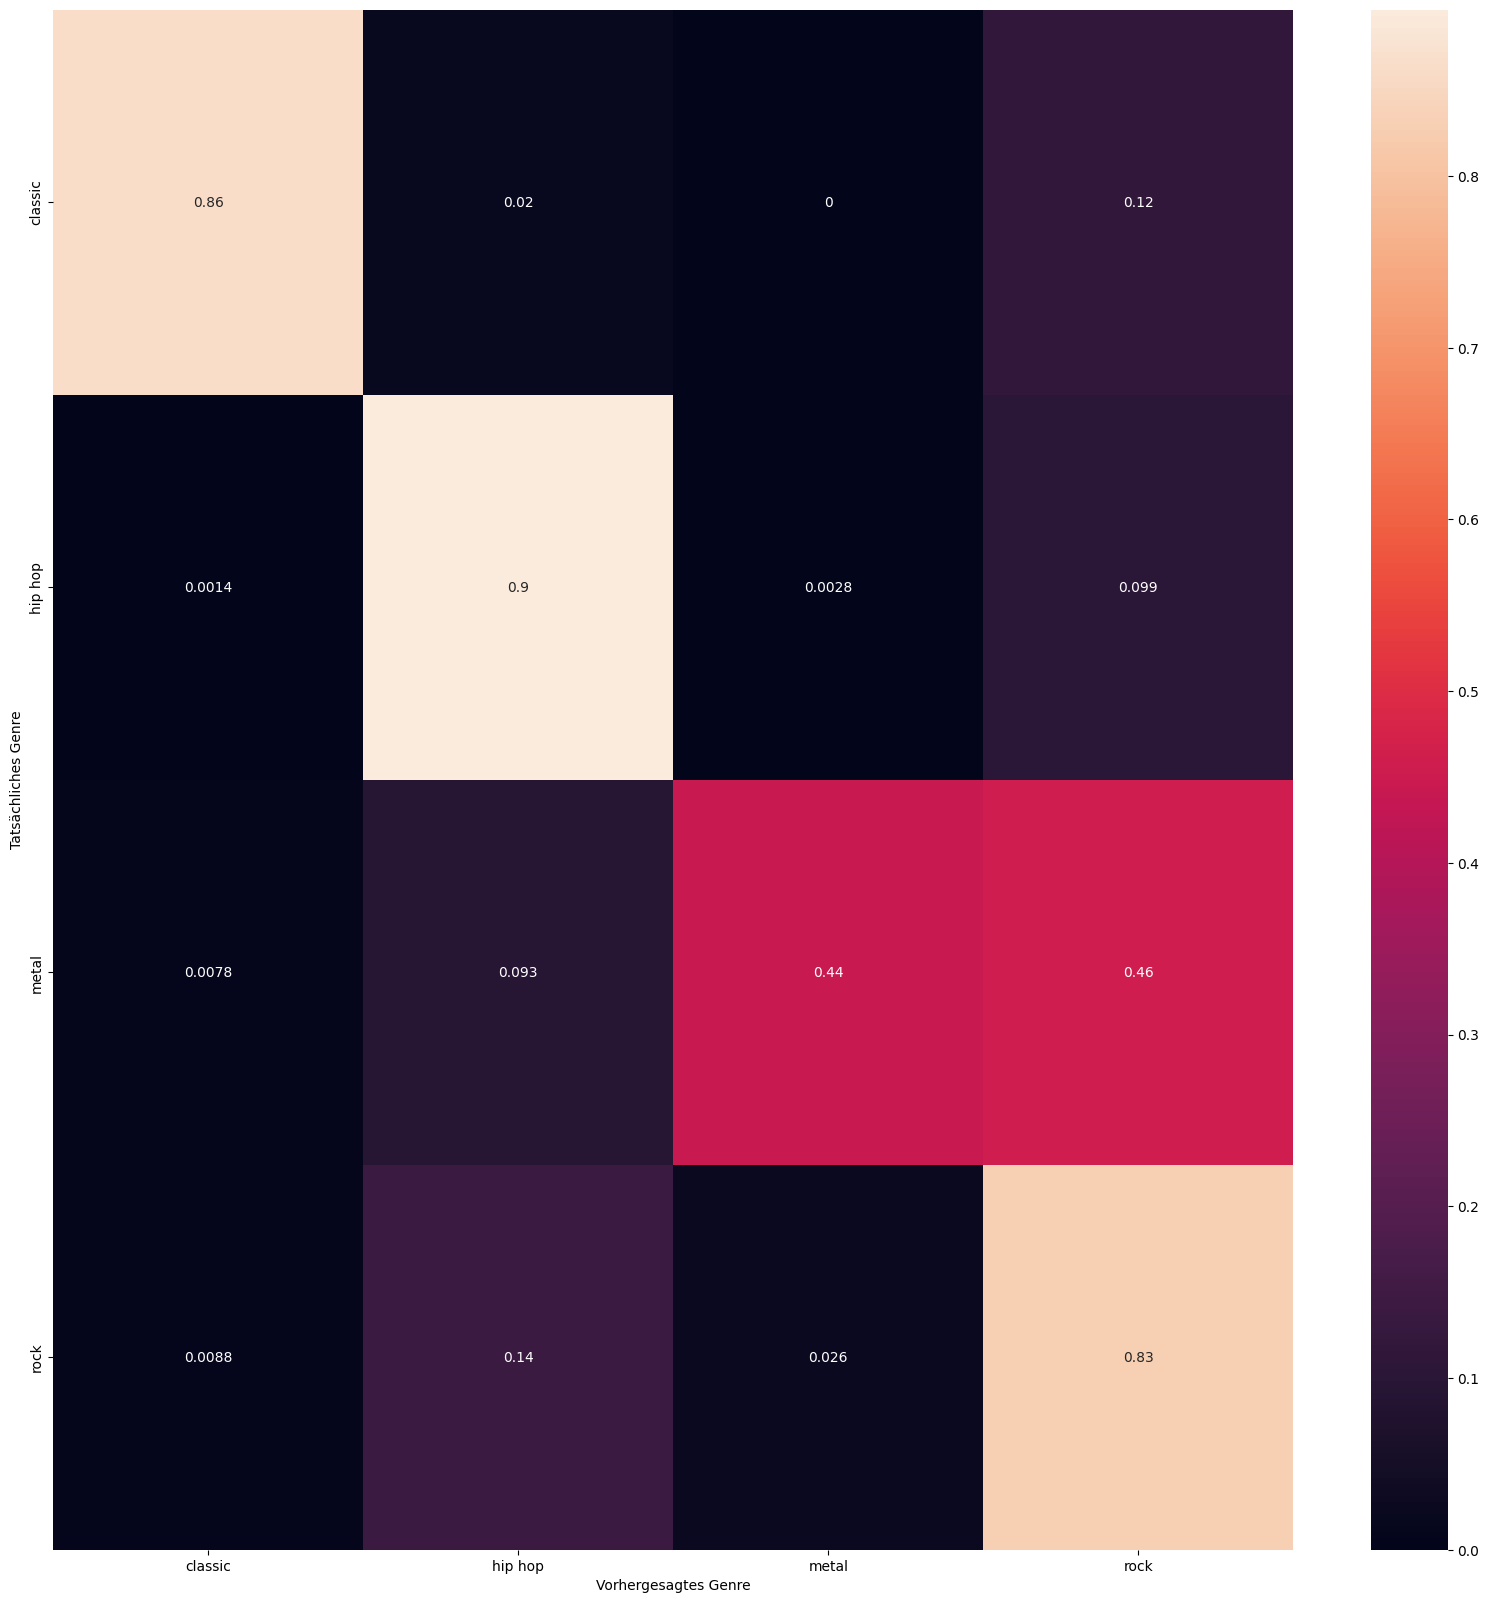

In [216]:
Y_pred_classes = np.argmax(Y_pred, axis=1)

for i in range(len(Y_pred_classes)):
    if label[Y_pred_classes[i]] == 'pop' and Y_pred[i, Y_pred_classes[i]] > 0.9:
        # Finde den Index des zweithöchsten Werts
        second_highest_index = np.argsort(Y_pred[i])[-2]
        Y_pred_classes[i] = second_highest_index
Y_test_classes = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_test_classes, Y_pred_classes, normalize='true')
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label)
plt.xlabel('Vorhergesagtes Genre')
plt.ylabel('Tatsächliches Genre')
plt.savefig('../figures/confusion_matrix.png')
plt.show()

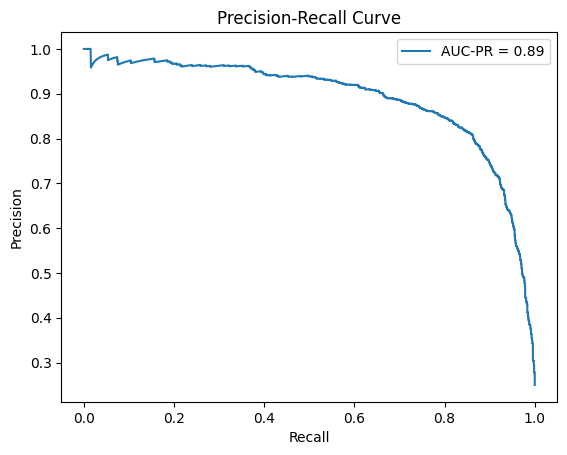

In [217]:
Y_prob = Y_pred

if isinstance(Y_test, pd.DataFrame):
    Y_test = Y_test.values
if isinstance(Y_prob, pd.DataFrame):
    Y_prob = Y_prob.values

precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())


# Berechne Precision, Recall und Schwellenwerte
precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())

# Berechne den AUC-PR
auc_pr = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

hip hop: AUC-PR = 0.937
classic: AUC-PR = 0.893
rock: AUC-PR = 0.851
metal: AUC-PR = 0.671


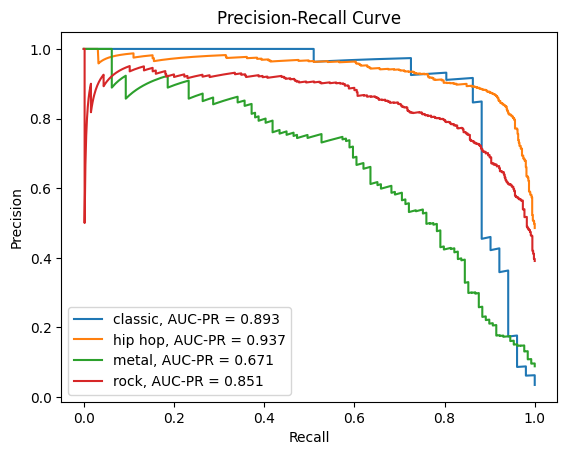

In [218]:
# Precision Recall Curve für jede Klasse einzeln

n_classes = Y_test.shape[1]

if isinstance(Y_test, np.ndarray):
    Y_test = pd.DataFrame(Y_test)
if isinstance(Y_pred, np.ndarray):
    Y_pred = pd.DataFrame(Y_pred)

auc_pr_values = []

# Für jede Klasse
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(Y_test.iloc[:, i], Y_pred.iloc[:, i])

    # Berechne den AUC-PR
    auc_pr = auc(recall, precision)
    auc_pr_values.append((label[i], auc_pr))

    plt.plot(
        recall,
        precision,
        label=f"{label[i]}, AUC-PR = {auc_pr:.3}",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")

# Genres nach AUC-PR-Wert sortieren
auc_pr_values_sorted = sorted(auc_pr_values, key=lambda x: x[1], reverse=True)

# Ausgabe der Genres und AUC-PR-Werte
for genre, auc_pr in auc_pr_values_sorted:
    print(f"{genre}: AUC-PR = {auc_pr:.3}")